In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import os 
from glob import glob 
import pickle
import cv2

# 초기 세팅 

In [2]:
image_size= 256 
image_channels =3

# 데이터 로드 

In [ ]:
!unzip '/content/drive/MyDrive/HY_데이터/생육환경최적화.zip'

In [4]:
folder_dir = glob('/content/train/*')
folder_dir.sort()

In [5]:
image_dir_lst = [] 
csv_dir_lst = []
label_dir_lst = [] 

for folder in folder_dir:
  image_dir = glob(os.path.join(folder,'image','*.png'))
  image_dir.extend(glob(os.path.join(folder,'image','*.jpg')))
  image_dir_lst.extend(image_dir)

  csv_dir = glob(os.path.join(folder,'meta','*.csv'))
  csv_dir_lst.extend(csv_dir)

  label_df = pd.read_csv(folder + '/label.csv')
  label_dir_lst.extend(np.array(label_df))
 
image_dir_lst.sort()
csv_dir_lst.sort()
label_dir_lst = np.array(pd.DataFrame(label_dir_lst).sort_values(by=0))

In [7]:
df = pd.DataFrame([image_dir_lst,csv_dir_lst,label_dir_lst[:,1]]).T
df.columns = ['IMG_DIR','META_DIR','LEAF_WEIGHT']
df['LEAF_WEIGHT'] = df['LEAF_WEIGHT'].map(float)

image_size = 2464,3280

# 데이터 제너레이터

## META 데이터 

In [9]:
columns = ['내부온도관측치'	,'외부온도관측치',	'내부습도관측치']

### 스케일링

In [10]:
def find_minmax_value(csv_dir):
  csv = pd.read_csv(csv_dir)
  csv = csv[columns]
  csv = csv.dropna()
  min = np.min(csv,axis=0).values.astype(np.float16)
  max = np.max(csv,axis=0).values.astype(np.float16)
  return min,max 

# min_lst = [] 
# max_lst = []   

# n = 0 
# for csv_dir in csv_dir_lst:
#   min,max = find_minmax_value(csv_dir)
#   if pd.isna(min[0]):
#     print(csv_dir)
#     n+=1
    
#   min_lst.append(min)
#   max_lst.append(max)

  

In [ ]:
# key_arange= np.arange(len(image_dir_lst))

# batch_key_arange = key_arange[0:32]

# key = batch_key_arange[0]

# def preproess_csv(key):
#   csv = pd.read_csv(csv_dir_lst[key])
#   csv = np.array(csv[].dropna().sample(20).reset_index().sort_values(by=['index']).drop(columns='index'))
#   return csv 

## **이미지 데이터 

In [12]:
from albumentations.augmentations.transforms import VerticalFlip,Transpose,GaussNoise,Normalize,RandomGamma,SmallestMaxSize,GridDistortion,Rotate,HorizontalFlip
from albumentations.augmentations.transforms import RandomBrightnessContrast,Transpose,CLAHE,LongestMaxSize,Transpose,Cutout
def image_augmentation(normal_image):
  import albumentations as A
  transform = A.Compose([
                         VerticalFlip(),
                         Rotate(),
                         RandomBrightnessContrast()
  ])
  augmentated_image = transform(image= normal_image)['image']
  return augmentated_image
  
def img_preprocess(img,augmentation):
  if augmentation:
    img = image_augmentation(img)
  img = cv2.resize(img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  img = img/255.
  return img 

def make_batch_img(batch_df_img_dir,augmentation):
  batch_imgs = np.zeros(len(batch_df_img_dir)*image_size*image_size*image_channels).reshape(-1,image_size,image_size,image_channels)
  for n,img_dir in enumerate(batch_df_img_dir):
    img = cv2.imread(img_dir)
    img = img_preprocess(img,augmentation)
    batch_imgs[n,:,:,:] = img
  return batch_imgs

## 라벨 

In [13]:
def label_scailng(temp_batch_label):
  global min,max
  return_value = (temp_batch_label-min)/(max-min)
  return return_value 
  
def init_minmax(df):
  min = np.min(df['LEAF_WEIGHT'],axis=0)
  max = np.max(df['LEAF_WEIGHT'],axis=0)
  return min,max

## 제너레이터 

In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
  def __init__(self,df,
                 batch_size: int,
               shuffle : bool = False,
               augmentation : bool = False,
               Train : bool = True):
        self.shuffle = shuffle 
        self.df = df  
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.Train = Train
        

        
  def __len__(self):
    return math.ceil(len(self.df) / self.batch_size)

  def on_epoch_end(self):
    self.indices = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.df = self.df.iloc[self.indices]
    
  def __getitem__(self, index):
    self.batch_df = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]

    batch_img = make_batch_img(self.batch_df['IMG_DIR'].values,self.augmentation)
    if self.Train:
      batch_label = self.batch_df['LEAF_WEIGHT'].values
      batch_label = label_scailng(batch_label)
      return batch_img.astype(float), batch_label
    else:
      return batch_img.astype(float)


    

# 모델

In [15]:
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import  Activation, AveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten
from tensorflow.keras.layers import BatchNormalization, Input, Dropout,Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import VGG19,EfficientNetV2S, ResNet50V2, vgg19,resnet_v2,EfficientNetB0
import math
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay

In [16]:
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
vgg.trainable = False

80150528/80134624 [==============================] - 2s 0us/step


In [17]:
def conv_layer(filter,image_input):
  x = Conv2D(filter, (2,2), padding ='same')(image_input)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = MaxPooling2D()(x)
  return x 

In [18]:
def make_model(img_input):
  img = vgg(img_input)
  for i in [128,32]:
    img = conv_layer(i,img)

  img = MaxPooling2D()(img)
  img = Flatten()(img)
  img = Dense(1,activation = 'sigmoid')(img)
  model = Model(img_input,img)
  return model 

## **Compile

In [19]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=100000)

# optimizer = tfa.optimizers.RectifiedAdam(
#     learning_rate=lr_schedule,
#     total_steps=10000,
#     warmup_proportion=0.1,
#     min_lr=1e-5,
# )

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'

)

     |████████████████████████████████| 1.1 MB 16.1 MB/s 


In [20]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [21]:
def NMAE(true, pred):
    mae = K.mean(K.abs(true-pred))
    score = mae / K.mean(K.abs(true))
    return score

## **콜백 
- model check point 바꿀 것 

In [22]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
class PlotLosses(Callback):
  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
plot_losses = PlotLosses()

#call backs 선언

## **wandb

In [ ]:
!pip install wandb
import wandb 
from wandb.keras import WandbCallback
def callback_init(n):
  wandb.init(project="Dacon_생육", entity="crimama-",name=f'0428_1_{n}fold')
  wandb.config = {
    "learning_rate": lr_schedule,
    "epochs": 20,
    "batch_size": 32
  }
  from tensorflow.keras.callbacks import ModelCheckpoint
  model_check_point = ModelCheckpoint(
    f'/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/생육환경최적화/model/0428/0428_1_{n}fold.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)
  return model_check_point
  # ... Define a model

## 학습 

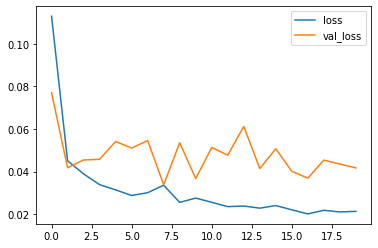

loss =  0.02133791148662567 , val_loss =  0.04177698865532875

Epoch 20: val_loss did not improve from 0.03386
40/40 [==============================] - 345s 9s/step - loss: 0.0213 - NMAE: 0.1294 - val_loss: 0.0418 - val_NMAE: 0.2874 - _timestamp: 1651169378.0000 - _runtime: 7023.0000


In [25]:

#Train - valid split 
from sklearn.model_selection import KFold
fold_index = np.arange(len(df))
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for n,(train, valid) in enumerate(kfold.split(fold_index)):
  train_df = df.iloc[train]
  valid_df = df.iloc[valid]
  
  #min,max 
  min,max = init_minmax(train_df)
  #제너레이터 

  train_generator = DataGenerator(train_df,
                                batch_size = 32,
                                shuffle = True,
                                augmentation = True,
                                Train = True)
  valid_generator = DataGenerator(valid_df,
                                batch_size=32,
                                shuffle = False,
                                augmentation = False,
                                Train = True)
  #콜백
  model_check_point = callback_init(n)
  callbacks = [plot_losses,WandbCallback(),model_check_point]
  
  
  #모델 선언 
  img_input = Input((image_size,image_size,image_channels))
  model = make_model(img_input) 

  model.compile(optimizer=optimizer,loss = root_mean_squared_error,metrics = [NMAE])
  history = model.fit(train_generator,validation_data = valid_generator, epochs=20,verbose=1,callbacks=callbacks)

# submission 

## 테스트 제너레이터

In [ ]:
test_dir = glob('/content/test/image/*')
test_dir.sort()
submission = pd.read_csv('/content/sample_submission.csv')
test_df = pd.DataFrame(test_dir)
test_df.columns = ['IMG_DIR']

In [ ]:
test_generator = DataGenerator(test_df,32,False,False,False)

In [ ]:
y_ = model.predict(test_generator)
predicted = y_*(max-min) + min 
submission['leaf_weight'] = predicted.squeeze()
submission_path = '/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/생육환경최적화/'
submission.to_csv(os.path.join(submission_path,'submission1.csv'),index=False)